In [1]:
!sudo ln -s /faceml/yolo_keras /faceml/notebooks

In [2]:
import os
import numpy as np

from keras import backend as K
from keras.models import load_model
from keras.layers import Input

from yolo_keras.utils import *
from yolo_keras.model import *
from PIL import Image

import argparse
import random
import matplotlib.patches as patches
import matplotlib.pyplot as plt


classes_path = "/faceml/yolo_keras/coco_classes.txt"
anchors_path = "/faceml/yolo_keras/yolo_anchors.txt"
model_path="/faceml/yolo_keras/yolo.h5"

with open(classes_path) as f:
    class_names = f.readlines()
    class_names = [c.strip() for c in class_names] 
num_classes = len(class_names)

# Get the anchor box coordinates for the model

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)

# Set the expected image size for the model
model_image_size = (416, 416)


# Create YOLO model
#home = os.path.expanduser("~")
#model_path = os.path.join(home, "yolo.h5")
yolo_model = load_model(model_path, compile=False)

# Generate output tensor targets for bounding box predictions
# Predictions for individual objects are based on a detection probability threshold of 0.3
# and an IoU threshold for non-max suppression of 0.45
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_model.output, anchors, len(class_names), input_image_shape,
                                    score_threshold=0.3, iou_threshold=0.45)

print("YOLO model ready!")

Using TensorFlow backend.


YOLO model ready!


In [3]:
def detect_objects(image):
    
    # normalize and reshape image data
    image_data = np.array(image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    # Predict classes and locations using Tensorflow session
    sess = K.get_session()
    out_boxes, out_scores, out_classes = sess.run(
                [boxes, scores, classes],
                feed_dict={
                    yolo_model.input: image_data,
                    input_image_shape: [image.size[1], image.size[0]],
                    K.learning_phase(): 0
                })
    return out_boxes, out_scores, out_classes

def show_objects(image, out_boxes, out_scores, out_classes):
    import random
    from PIL import Image
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    %matplotlib inline 
    
    # Set up some display formatting
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    # Plot the image
    img = np.array(image)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    # Set up padding for boxes
    img_size = model_image_size[0]
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    # Use a random color for each class
    unique_labels = np.unique(out_classes)
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    # process each instance of each class that was found
    for i, c in reversed(list(enumerate(out_classes))):

        # Get the class name
        predicted_class = class_names[c]
        # Get the box coordinate and probability score for this instance
        box = out_boxes[i]
        score = out_scores[i]

        # Format the label to be added to the image for this instance
        label = '{} {:.2f}'.format(predicted_class, score)

        # Get the box coordinates
        top, left, bottom, right = box
        y1 = max(0, np.floor(top + 0.5).astype('int32'))
        x1 = max(0, np.floor(left + 0.5).astype('int32'))
        y2 = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        x2 = min(image.size[0], np.floor(right + 0.5).astype('int32'))

        # Set the box dimensions
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        
        # Add a box with the color for this class
        color = bbox_colors[int(np.where(unique_labels == c)[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        
    plt.axis('off')
    plt.show()
    

In [4]:
def show_image(im, x1, y1, x2, y2):
    fig,ax = plt.subplots(1)
    plt.figure(figsize=model_image_size)
    ax.imshow(im)
    if (x1 is None):
        return
    for i in range(len(x1)):
        rect = patches.Rectangle((x1[i],y1[i]),x2[i]-x1[i],y2[i]-y1[i],linewidth=1,edgecolor='r',facecolor='none', label=i)
        centerx = x1[i] + (x2[i]-x1[i])/2
        centery = y1[i] + (y2[i]-y1[i])/2
        ax.text(centerx, centery,str(i))
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

Matched 8 person in /faceml/sampleimages/newyork.jpg


<Figure size 432x288 with 0 Axes>

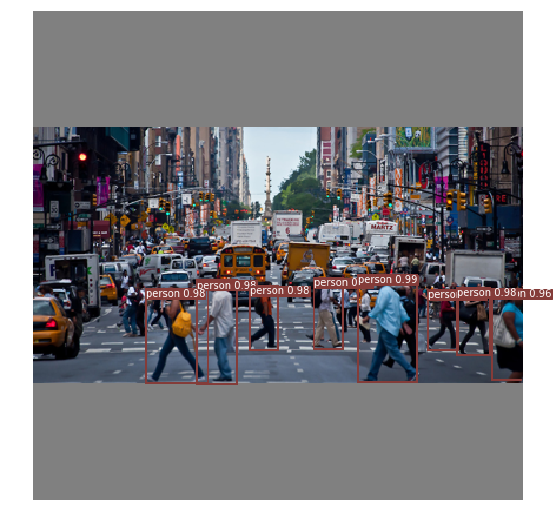

In [5]:
import os
from PIL import Image

image_file = "/faceml/sampleimages/newyork.jpg"
classname="person" #try setting this to car
requiredCount=0 #0: ignore, else match count
requiredConfidence=80
requiredSize=0 #try with 2
    
# Load image
orgimage = Image.open(image_file)

# Resize image for model input
image = letterbox_image(orgimage, tuple(reversed(model_image_size)))
iw, ih = image.size
image_area=iw*ih

# Detect objects in the image
out_boxes, out_scores, out_classes = detect_objects(image)
objects=[class_names[out_classes[i]] for i in range(len(out_classes))]

if classname!="" and (classname in objects):
    match=0
    index=0
    filter_boxes, filter_scores, filter_objects =[],[],[]
    for i in range(len(out_classes)):
        if (objects[i]==classname and out_scores[i]*100>=requiredConfidence):
                index=i
                box_height=(out_boxes[i][2]-out_boxes[i][0])
                box_width=(out_boxes[i][3]-out_boxes[i][1])
                box_area=box_width*box_height
                if ((box_area/image_area)*100 > requiredSize):
                    match=match+1
                    filter_boxes.append(out_boxes[i])
                    filter_scores.append(out_scores[i])
                    filter_objects.append(out_classes[i])

    print('Matched {} {} in {}'.format(match, classname, image_file))
    show_objects(image, filter_boxes, filter_scores, filter_objects) 
    #k=np.concatenate( filter_boxes, axis=0 )    
    #k=k.reshape(match,4)
    #show_image(image, k[:,1],k[:,0],k[:,3],k[:,2])
else:
    print('Found {} objects in {}'.format(len(out_boxes), image_file))

    # Display the image with bounding boxes
    show_objects(image, out_boxes, out_scores, out_classes)

    objects=[class_names[out_classes[i]] for i in range(len(out_classes))]
    print(objects)    